In [102]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import warnings
from pathlib import Path
import jax.numpy as jnp
import numpy as np
import pandas as pd

# GPUDrive dependencies
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 120
warnings.filterwarnings("ignore")

### Configurations

In [103]:
BASE_DIR = "./notebooks/"
SCENARIO_ID = "11671609ebfa3185"

### Load debug scenario and saved samples 

We saved the following inputs from the same scenario:
- Processed VBD inputs (used in waymax)
- Processed VBD inputs (used in gpudrive)

In [329]:
with open(f"{BASE_DIR}waymax_vbd_sample_{SCENARIO_ID}.pkl", "rb") as f:
    waymax_vbd_data = pickle.load(f)

with open(f"{BASE_DIR}gpudrive_vbd_sample_{SCENARIO_ID}.pkl", "rb") as f:
    gpudrive_vbd_data = pickle.load(f)

### Helper functions

In [330]:
def make_heatmaps(waymax_vbd_data, gpudrive_vbd_data, array_name, index, feature_name, 
                  share_axes=True, share_color_scale=True, x_label="Time step", y_label="Agent index"):
    
    # Determine vmin, vmax, cmap, and center based on sharing options
    if share_color_scale:
        vmin = min(waymax_vbd_data[array_name][:, :, index].min(),
                   gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].min())
        vmax = max(waymax_vbd_data[array_name][:, :, index].max(),
                   gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].max())
    else:
        vmin = None 
        vmax = None 

    if vmin is not None and vmin >= 0:
        cmap = 'Reds'
        center = None
    else:
        cmap = 'bwr'
        center = 0

    # Set up subplots with optional shared axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=share_axes, sharey=share_axes)

    # Waymax VBD data heatmap
    sns.heatmap(
        waymax_vbd_data[array_name][:, :, index], cmap=cmap, center=center, linewidth=.5,
        vmin=vmin, vmax=vmax, cbar=False, annot=False, ax=axs[0]
    )
    axs[0].set_title("Waymax VBD data")
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)

    # GPUDrive VBD data heatmap
    sns.heatmap(
        gpudrive_vbd_data[array_name].squeeze(0)[:, :, index], cmap=cmap, center=center, linewidth=.5,
        vmin=vmin, vmax=vmax, cbar=False, annot=False, ax=axs[1]
    )
    axs[1].set_title(f"GPUDrive VBD data [min: {gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].min()}, max: {gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].max():.2}]")
    axs[1].set_xlabel(x_label)

    # Add separate color bars if axes and color scales are not shared
    if not share_color_scale:
        # Color bar for the first heatmap
        cbar1 = fig.colorbar(axs[0].collections[0], ax=axs[0], orientation="vertical", pad=0.04)
        cbar1.set_label(f"{feature_name} (Waymax)")

        # Color bar for the second heatmap
        cbar2 = fig.colorbar(axs[1].collections[0], ax=axs[1], orientation="vertical", pad=0.04)
        cbar2.set_label(f"{feature_name} (GPUDrive)")
    else:
        cbar = fig.colorbar(axs[0].collections[0], ax=axs, orientation="vertical", pad=0.04)
        cbar.set_label(f"{feature_name}")

    plt.show()


### **Overview**

In [331]:
waymax_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

In [332]:
gpudrive_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

## **Inputs**

### ❌ 1. Agents history [todo: needs deep dive]

- What:
    - First $t$ time steps of the log playback trajectories. Used to predict trajectories
- Shape: Number of agents (32), time steps (12), features (8)
- **Summary** of feature comparison:
    - `(x, y)`: ❌*
        - Note:
    - `yaw`: ❌
        - Notes: Why is the GPUDrive yaw always positive? Waymax yaw can be negative. Negative yaw angle usually indicates rotation to the left, so this seems important.
    - `vel_x, vel_y`: ❌*
        - Kind of surprising that there is so much deceleration (negative velocities)
        - Patterns look very different compared to waymax
    - `veh_len, veh_width, veh_height`: ❌

- Checklist:
    - ✔️: Is the order or features aligned? -> yes
    - ✔️: Ensure that the `yaw` is mapped from [0,2pi] -> [-pi, pi]
    - _todo_: Find out where diffs come from

---
$*$ Not the same, but these values cannot be compared because we substract the mean in GPUDrive to center these at 0, which is not done in Waymax.

In [333]:
waymax_vbd_data['agents_history'].shape, gpudrive_vbd_data['agents_history'].squeeze(0).shape

((32, 12, 8), (32, 12, 8))

In [334]:
time_step = 0

In [335]:
feature_names = {
    0: "x",
    1: "y",
    2: "yaw",
    3: "velocity_x",
    4: "velocity_y",
    5: "vehicle_length",
    6: "vehicle_width",
    7: "vehicle_height"
}


#### Yaw 

In [342]:
gpudrive_vbd_data['agents_history'][:, :, 2]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.72722168e+01,  3.23500977e+01,  3.07467318e+00,
         -6.65283203e+00, -2.44140625e-02,  4.55015659e+00,
          2.01722050e+00,  1.00000000e+00],
        [ 1.15910645e+01,  2.77480469e+01,  3.61526704e+00,
         -1.95312500e-02,  2.92968750e-02,  4.48535204e+00,
          2.01758647e+00,  1.00000000e+00],
        [ 1.17468262e+01,  2.38881836e+01,  3.69327211e+00,
         -1.46484375e-02,  9.76562500e-03,  4.64210320e+00,
          2.02009487e+00,  1.00000000e+00],
        [ 4.18652344e+01,  2.45576172e+01,  2.38069510e+00,
          4.15039062e-02,  3.90625000e-02,  4.62185097e+00,
          2.09067822e+00,  1.00000000e+00],
        [ 6.36328125e+00,  4.32124023e+01,  5.35535431e+00,
         -2.31933594e-01,  1.07421875e-01,  4.78441858e+00,
          2.14586616e+00,  1.00000000e+00],
        [ 4.8471

In [336]:
gpudrive_vbd_data['agents_history'][:, :, 2], gpudrive_vbd_data['agents_history'][:, :, 2].max()

(-7.381836, 75.17749)

In [341]:
gpudrive_vbd_data['agents_history'][:, :, 2].max()

75.17749

In [337]:
#waymax_vbd_data['agents_history'][:, :, 2]

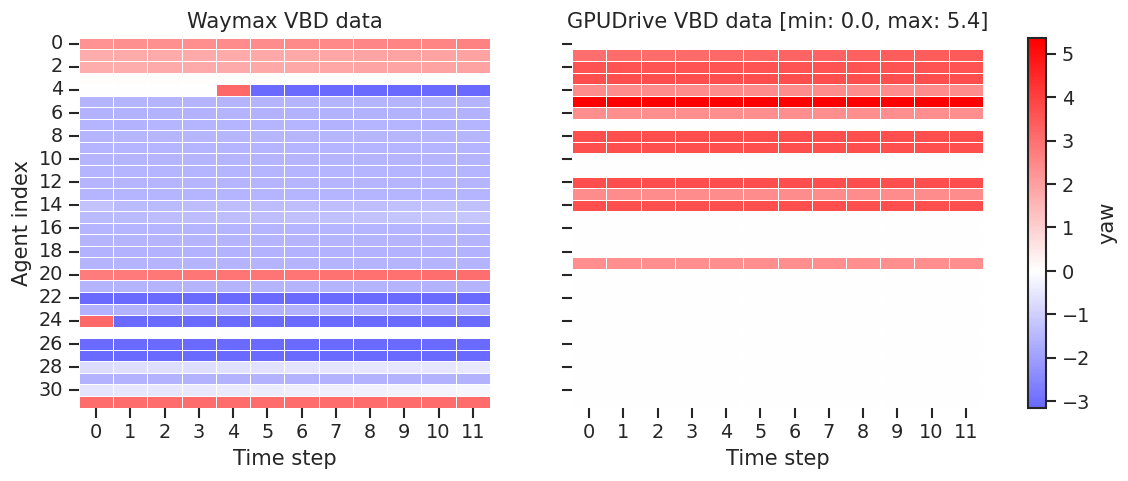

In [338]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=2, 
    feature_name=feature_names[2]
)

#### Velocity

In [322]:
gpudrive_vbd_data['agents_history'].squeeze(0).shape

(32, 12, 8)

In [323]:
gpudrive_vbd_data['agents_history'].squeeze(0)[1, :, 4]

array([ 0.29296875,  0.29296875, -0.02441406, -0.3955078 , -0.47851562,
       -0.8251953 , -0.95214844, -1.2792969 , -1.4746094 , -1.8066406 ,
       -1.8847656 , -2.2607422 ], dtype=float32)

In [324]:
# TODO:
# - Align the agent ids we control
# 

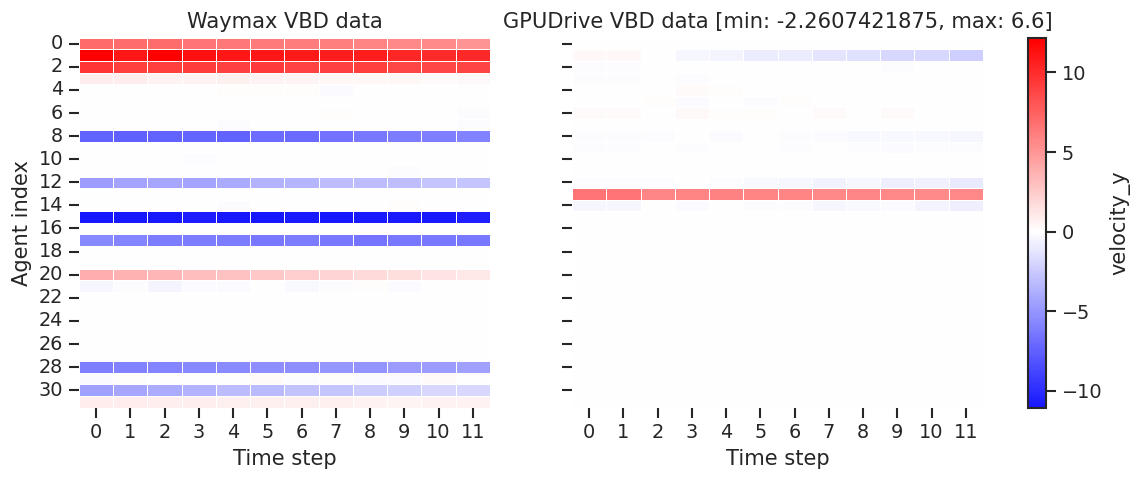

In [325]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data,
    array_name='agents_history', 
    index=4, 
    feature_name=feature_names[4]
)

In [234]:
gpudrive_vbd_data['agents_history'].squeeze(0)[:, :, 3].max(), gpudrive_vbd_data['agents_history'].squeeze(0)[:, :, 4].max()

(0.13916016, 6.6064453)

#### Vehicle length

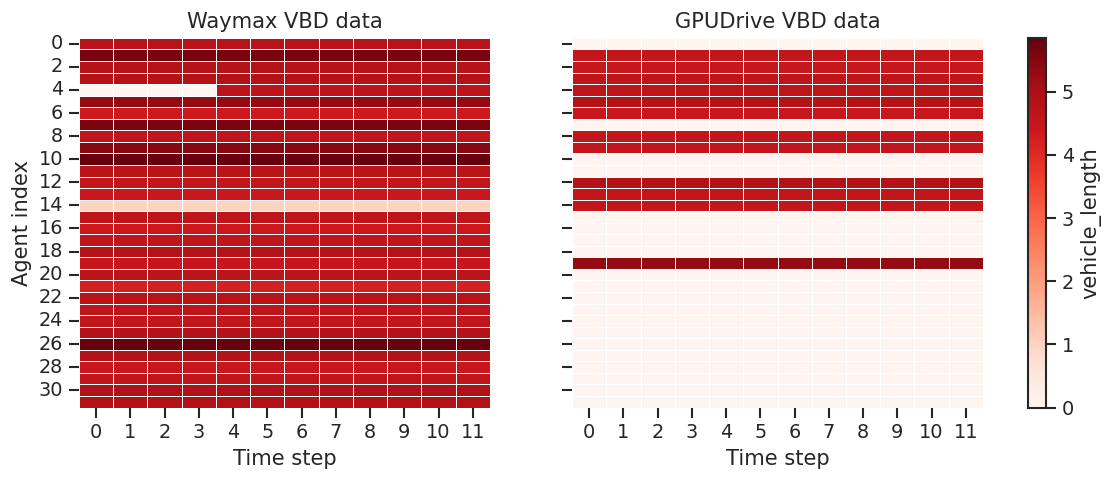

In [235]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data,
    array_name='agents_history', 
    index=5, 
    feature_name=feature_names[5]
)

#### Vehicle width

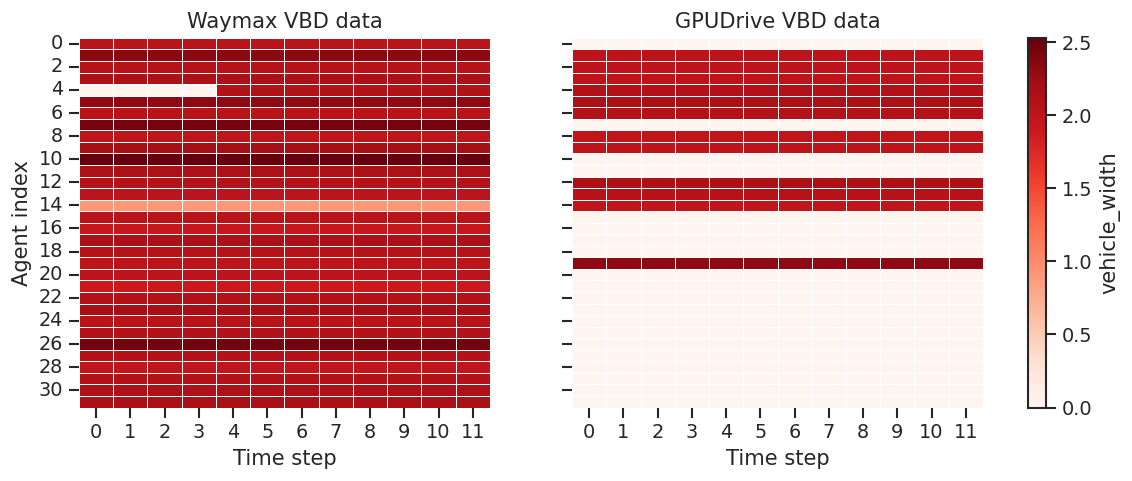

In [236]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=6, 
    feature_name=feature_names[6]
)

#### Vehicle height

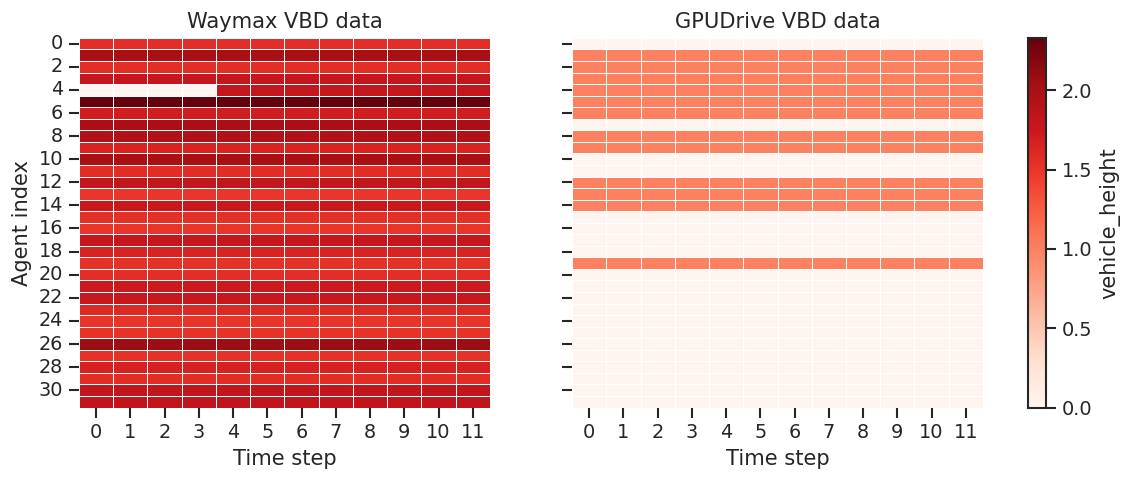

In [237]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=7, 
    feature_name=feature_names[7]
)

### ✅ 2. Agents interested 


- What:
    - Encodes what we control. `10` means we control the agent; `1` means we don't control the agent (10 is an arbitrary value adopted from VBD code)
- Notes:
    - In GPUDrive we control 12 agents whereas in waymax its 5 (this doesn't have to be a problem though)
    - Order is different but that shouldn't matter for the model performance
- Checklist:
    - ✔️: Values aligned? (1, 10) -> yes



In [238]:
waymax_vbd_data['agents_interested'].shape, gpudrive_vbd_data['agents_interested'].squeeze(0).shape

((32,), (32,))

In [239]:
waymax_vbd_data['agents_interested'], (waymax_vbd_data['agents_interested'] == 10).sum()

(array([10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       dtype=int32),
 5)

In [240]:
gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), (gpudrive_vbd_data['agents_interested'] == 10).sum()

(array([ 1, 10, 10, 10, 10, 10, 10,  1, 10, 10,  1,  1, 10, 10, 10,  1,  1,
         1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 12)

In [241]:
np.equal(gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), waymax_vbd_data['agents_interested']), np.equal(gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), waymax_vbd_data['agents_interested']).sum()

(array([False,  True,  True,  True,  True, False, False,  True, False,
        False,  True,  True, False, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
 23)

### ✅ 3. Agents type

- What:
    - Encodes object type: `metadata.object_types`, can be `(Unset=0, Vehicle=1, Pedestrian=2, Cyclist=3, Other=4)`
- Notes:
    - I don't understand why none of the VBD elements are 0, I mean, some of these must be padding agents.
    - Other than that, things look good
- Checklist:
    - ✔️ Check types (we see a 1 and a 2 in both arrays)

In [242]:
waymax_vbd_data['agents_type'].shape, gpudrive_vbd_data['agents_type'].squeeze(0).shape

((32,), (32,))

In [243]:
waymax_vbd_data['agents_type']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [244]:
gpudrive_vbd_data['agents_type']

array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### ❌ 4. Agents future

- Shape: `(32, 80, 5) ; (max_controlled_agents, remaining_timesteps, features)`
- What:
    - The _log playback_ futures starting at $t=11$
    - This tensor only contains info in the 0th index, the rest is fille with zeros.
    - _todo_: Check how this information is used in the VBD model
- Notes:
    - _todo_: Ask why VBD's futures are zero (only the 0th time index has info)
- Checklist:
    - ✔️ Is the order of the features the same? -> yes
 

In [245]:
waymax_vbd_data['agents_future'].shape, gpudrive_vbd_data['agents_future'].squeeze(0).shape

((32, 80, 5), (32, 80, 5))

In [246]:
agents_future_feat_names = {
    0: "x",
    1: "y",
    2: "yaw",
    3: "vel_x",
    4: "vel_y",
}

In [247]:
time_step = 1

waymax_vbd_data['agents_future'][:, :, 3]

array([[ -8.935547  ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.3359375 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.7988281 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.10742188,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  8.691406  ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-13.203125  ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)

In [248]:
gpudrive_vbd_data['agents_future'].squeeze(0)[:, time_step, 0]

array([ 0.        , 10.645508  , 11.585693  , 11.684326  , 41.816162  ,
        6.36792   , 48.346436  ,  0.        ,  6.0566406 ,  6.0324707 ,
        0.        ,  0.        , -0.13598633, 68.92383   , -0.6652832 ,
        0.        ,  0.        ,  0.        ,  0.        , 36.339355  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ], dtype=float32)

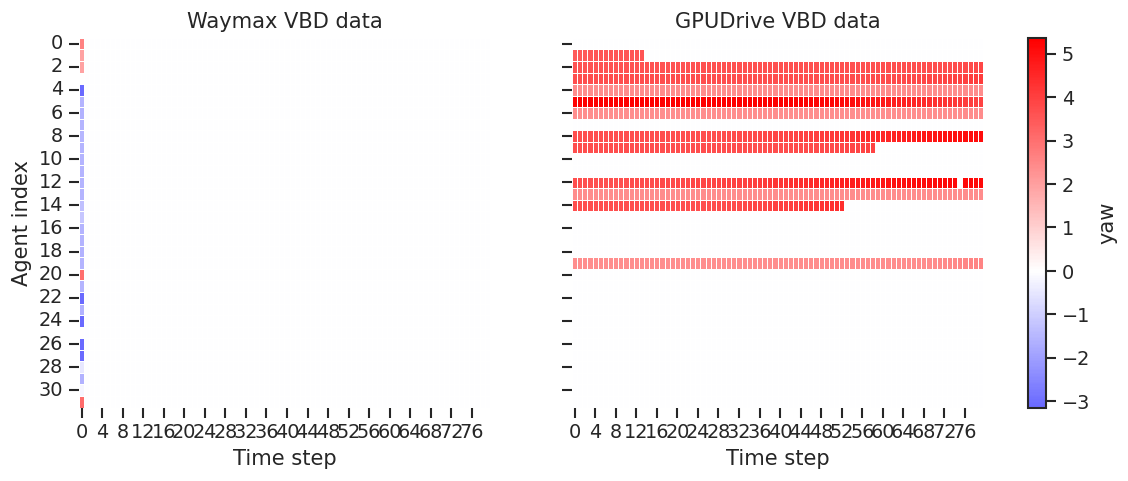

In [249]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_future',
    index=2, 
    feature_name=agents_future_feat_names[2]
)

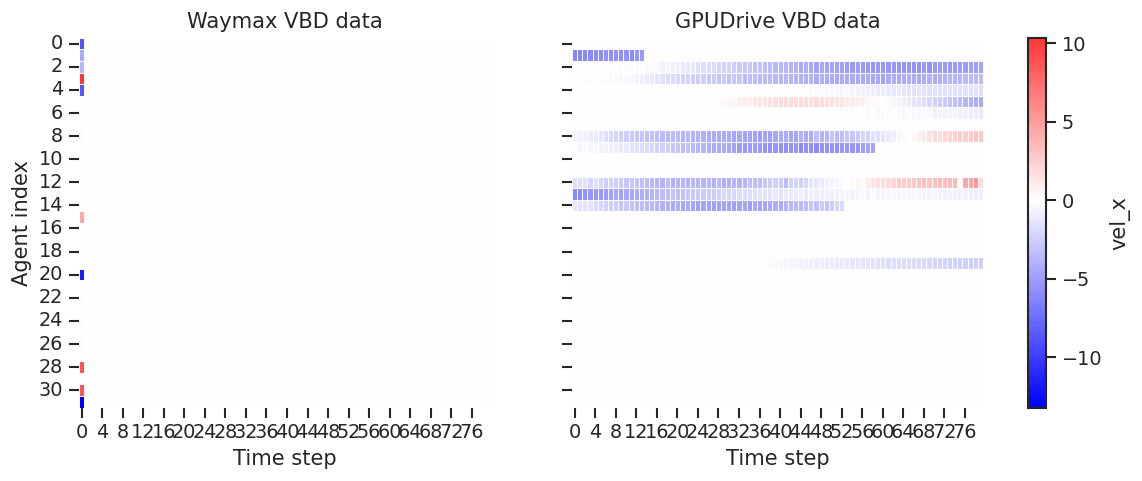

In [250]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_future',
    index=3, 
    feature_name=agents_future_feat_names[3]
)

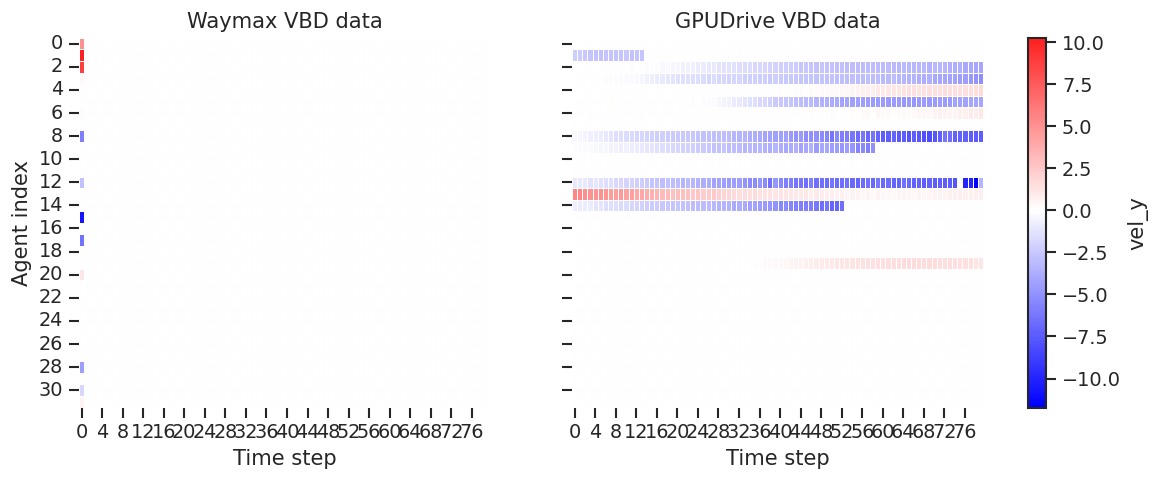

In [251]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_future',
    index=4, 
    feature_name=agents_future_feat_names[4]
)

###  ✅ 5. Traffic light points

- Not supported in GPUDrive, but fairly confident that this doesn't cause any problems.

In [252]:
waymax_vbd_data['traffic_light_points'].shape, gpudrive_vbd_data['traffic_light_points'].squeeze(0).shape

((16, 3), (16, 3))

In [253]:
waymax_vbd_data['traffic_light_points'], gpudrive_vbd_data['traffic_light_points']

(array([[8.4860176e+03, 1.4842620e+03, 4.0000000e+00],
        [8.4883740e+03, 1.4843839e+03, 4.0000000e+00],
        [8.4918564e+03, 1.4845614e+03, 4.0000000e+00],
        [8.5254482e+03, 1.4642095e+03, 4.0000000e+00],
        [8.4950791e+03, 1.4848386e+03, 4.0000000e+00],
        [8.5254482e+03, 1.4677252e+03, 4.0000000e+00],
        [8.5249268e+03, 1.4710636e+03, 4.0000000e+00],
        [8.5027246e+03, 1.4853600e+03, 3.0000000e+00],
        [8.5027246e+03, 1.4853600e+03, 3.0000000e+00],
        [8.4991396e+03, 1.4852823e+03, 3.0000000e+00],
        [8.4836152e+03, 1.4840068e+03, 4.0000000e+00],
        [8.5245918e+03, 1.4773523e+03, 4.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32),
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0

### 6. Polylines

- Shape: `(max_polylines, num_points_polyline, features)`
    - Features: `(p_x, p_y, heading, traffic_light_state, lane_type)`
- What: Encodes the road graph 
- Notes:
    - Again, since we are centering the coordinates at zero, these cannot be compared directly
    - _todo_: Find out why there are more polyline points in waymax.
- Checklist:
    - ✔️ Is the feature order the same?
    - ✔️ Do we process the road points in the same way?
    - ✔️ Are the road object types aligned?


In [278]:
waymax_vbd_data['polylines'].shape, gpudrive_vbd_data['polylines'].squeeze(0).shape

((256, 30, 5), (256, 30, 5))

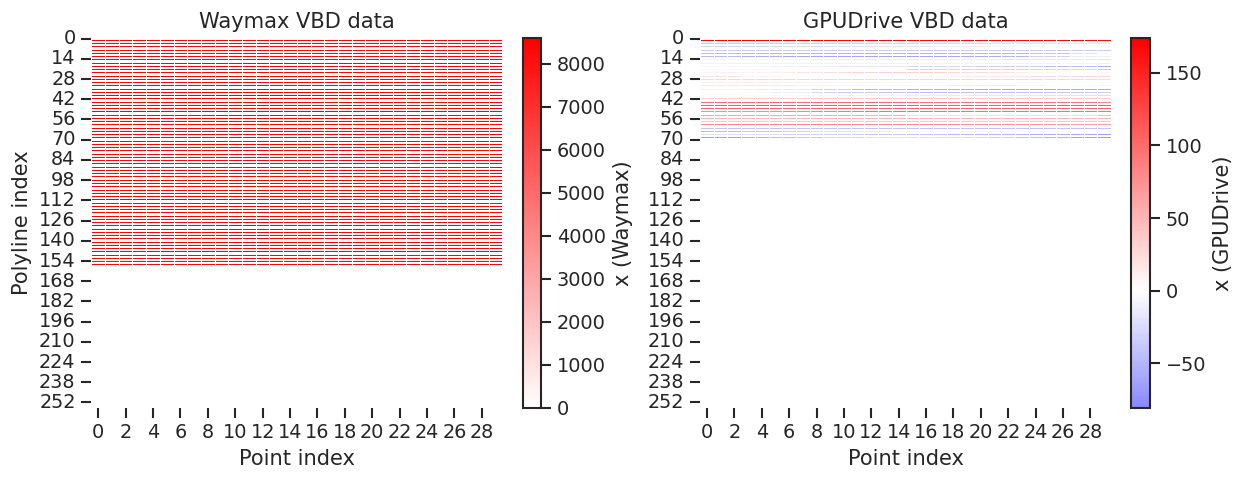

In [279]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='polylines',
    index=0, 
    feature_name="x",
    share_axes=False,
    share_color_scale=False,
    x_label='Point index',
    y_label='Polyline index',
)

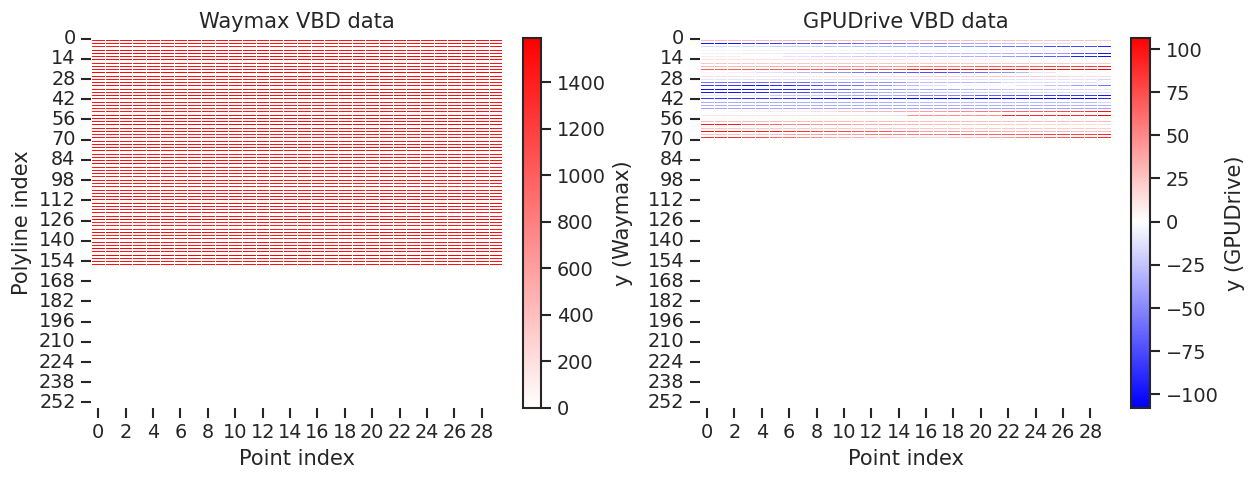

In [280]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='polylines',
    index=1, 
    feature_name='y',
    share_axes=False,
    share_color_scale=False,
    x_label='Point index',
    y_label='Polyline index',
)

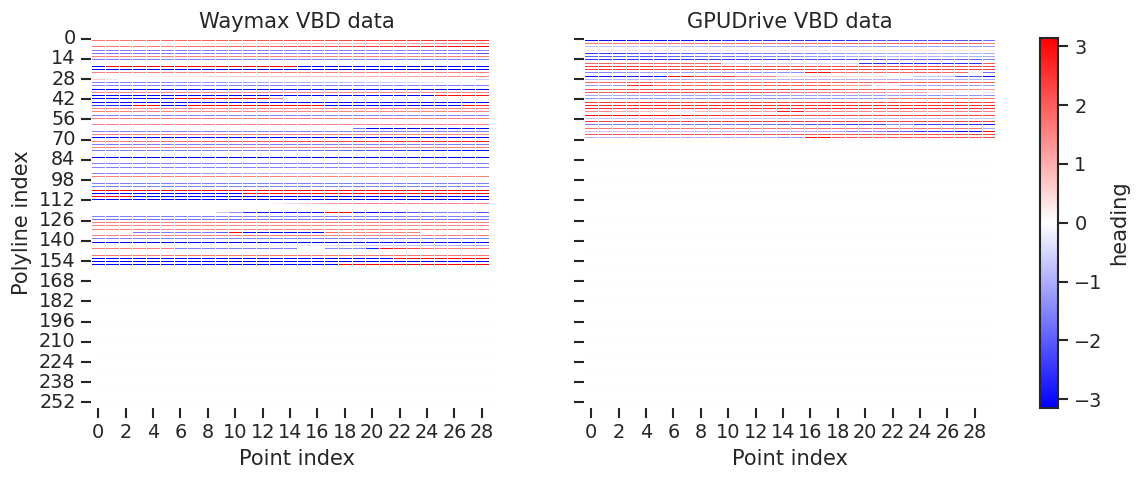

In [281]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='polylines',
    index=2, 
    feature_name='heading',
    x_label='Point index',
    y_label='Polyline index',
)

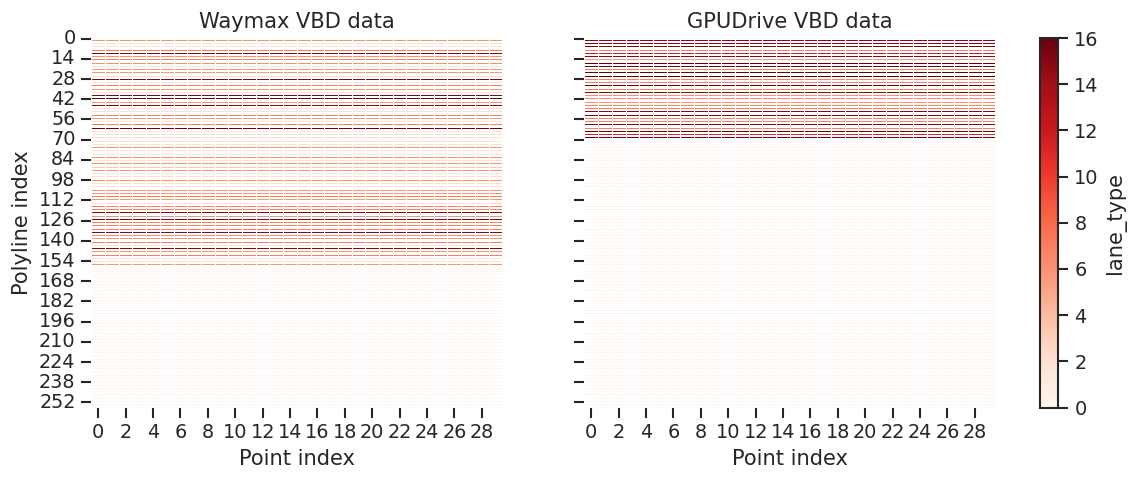

In [282]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='polylines',
    index=4, 
    feature_name='lane_type',
    x_label='Point index',
    y_label='Polyline index',
)

In [277]:
# Can't be compared directly
waymax_vbd_data['polylines'][:, :, 0], gpudrive_vbd_data['polylines'].squeeze(0)[:, :, 0]

(array([[8478.251 , 8477.762 , 8477.271 , ..., 8462.099 , 8461.609 ,
         8460.631 ],
        [8501.151 , 8501.0625, 8500.936 , ..., 8484.239 , 8483.419 ,
         8482.19  ],
        [8478.13  , 8479.614 , 8481.1   , ..., 8521.192 , 8522.677 ,
         8524.657 ],
        ...,
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ]], dtype=float32),
 array([[-80.34973, -80.34973, -80.34973, ..., -46.41858, -46.41858,
         -46.68335],
        [174.     , 174.     , 174.     , ..., 167.73218, 167.73218,
         166.2826 ],
        [166.37476, 166.37476, 166.37476, ..., 166.37476, 166.37476,
         166.37476],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,

## **Outputs** (predicted trajectories)